In [1]:
%load_ext autoreload
%autoreload 2

In [141]:
# Dataset imports:
from data.moleDataset import *

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, random_split

# Model imports:
from model import *

# Train and evaluation imports:
from train import train

# General imports:
import os
import json
import math

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Defining the device

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print(f'Using: {torch.cuda.get_device_name(0)}')
print(f'Current device: {device}')

Using: NVIDIA GeForce GTX 1060 6GB
Current device: cuda


# Data preprocessing:

### Getting the mean and standard deviation of the dataset in order to apply normalization on the data:

In [5]:
# Getting the path to the .txt file that contains the mean and std:
DATA_STATS_FILE_NAME = "dataset_stats.txt"
STATS_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', DATA_STATS_FILE_NAME)

# Reading the statistics file:
stats_dict = None
with open(STATS_FILE_PATH, 'r') as stats_file:
    stats_dict = json.loads(stats_file.read())
    
mean, std = stats_dict['mean'], stats_dict['std']

print(f'Dataset mean: \t\t\t{mean}\nDataset standard deviation: \t{std}')

Dataset mean: 			[0.4944856143767711, 0.4950292797617727, 0.4954058302766022]
Dataset standard deviation: 	[0.28984177278042145, 0.28989603043370027, 0.28941759149050483]


### Creating the preprocessing operations that the images will undergo:

In [57]:
image_preprocessing = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.transforms.Normalize(mean, std),
                            lambda image : transforms.functional.adjust_sharpness(image,
                                                                                sharpness_factor=2)])

# This transform is the same as the above one but it does not convert to Tensor
# So the returned image from the dataset can be visualized easier.
image_preprocessing_test = transforms.Compose([
                            transforms.transforms.Normalize(mean, std),
                            lambda image : transforms.functional.adjust_sharpness(image,
                                                                                sharpness_factor=2)])

# Defining the dataset:

In [58]:
# Creating the dataset instance:
test_dataset = MoleDataset(transform=image_preprocessing)

### The dataset class distribution:

In [59]:
data_dist = test_dataset.get_data_distribution()
data_dist

{'akiec': 327,
 'bcc': 514,
 'bkl': 1099,
 'df': 115,
 'mel': 1113,
 'nv': 6705,
 'vasc': 142}

### Plotting the data distribution:

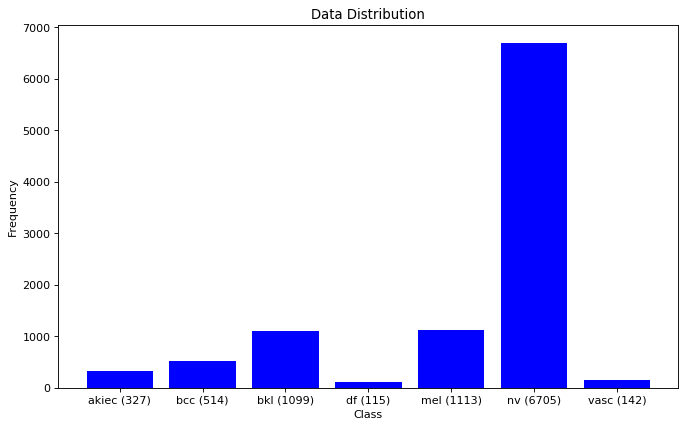

In [60]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Overfitting Experiment:

### Creating a subset for training:

In [119]:
SUBSET_SIZE = 100
selected_class = 2
sample_array_1 = test_dataset.get_class_indecies(selected_class)

selected_class = 4
sample_array_2 = test_dataset.get_class_indecies(selected_class)

sample_array = sample_array_1 + sample_array_2

subset_indicies = np.random.choice(sample_array, SUBSET_SIZE, replace=False)
train_subset = Subset(test_dataset, subset_indicies)

In [120]:
subset_loader = DataLoader(train_subset, shuffle=True, batch_size=32)

### Creating the model:

In [121]:
model_overfit = SkinCancerModel()

### The hyperparameters, the loss function and the optimizer:

In [122]:
learning_rate = 5e-3
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_overfit.parameters(), lr=learning_rate, momentum=momentum)

In [123]:
epochs = 40

### Overfitting the model:

In [124]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model_overfit,
                                                                            train_loader=subset_loader,
                                                                            validation_loader=subset_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/40 [00:00<?, ?it/s]

Evaluating epoch...


  2%|▎         | 1/40 [00:10<06:37, 10.18s/it]

Epoch: 0 | Train_acc: 61.00% | Val_acc: 61.00% | Loss: 21.20 | Runtime: 10.18 seconds
Evaluating epoch...


  5%|▌         | 2/40 [00:18<05:39,  8.94s/it]

Epoch: 1 | Train_acc: 60.00% | Val_acc: 60.00% | Loss: 3.43 | Runtime: 8.07 seconds
Evaluating epoch...


  8%|▊         | 3/40 [00:26<05:10,  8.40s/it]

Epoch: 2 | Train_acc: 60.00% | Val_acc: 60.00% | Loss: 4.10 | Runtime: 7.74 seconds
Evaluating epoch...


 10%|█         | 4/40 [00:33<04:55,  8.20s/it]

Epoch: 3 | Train_acc: 70.00% | Val_acc: 70.00% | Loss: 3.83 | Runtime: 7.91 seconds
Evaluating epoch...


 12%|█▎        | 5/40 [00:42<04:52,  8.35s/it]

Epoch: 4 | Train_acc: 68.00% | Val_acc: 68.00% | Loss: 2.25 | Runtime: 8.62 seconds
Evaluating epoch...


 15%|█▌        | 6/40 [00:50<04:39,  8.22s/it]

Epoch: 5 | Train_acc: 76.00% | Val_acc: 76.00% | Loss: 2.22 | Runtime: 7.95 seconds
Evaluating epoch...


 18%|█▊        | 7/40 [00:58<04:28,  8.14s/it]

Epoch: 6 | Train_acc: 65.00% | Val_acc: 65.00% | Loss: 2.30 | Runtime: 7.97 seconds
Evaluating epoch...


 20%|██        | 8/40 [01:06<04:17,  8.06s/it]

Epoch: 7 | Train_acc: 75.00% | Val_acc: 75.00% | Loss: 2.60 | Runtime: 7.90 seconds
Evaluating epoch...


 22%|██▎       | 9/40 [01:14<04:07,  7.98s/it]

Epoch: 8 | Train_acc: 77.00% | Val_acc: 77.00% | Loss: 2.03 | Runtime: 7.79 seconds
Evaluating epoch...


 25%|██▌       | 10/40 [01:21<03:57,  7.91s/it]

Epoch: 9 | Train_acc: 78.00% | Val_acc: 78.00% | Loss: 2.29 | Runtime: 7.76 seconds
Evaluating epoch...


 28%|██▊       | 11/40 [01:29<03:47,  7.85s/it]

Epoch: 10 | Train_acc: 75.00% | Val_acc: 75.00% | Loss: 1.92 | Runtime: 7.70 seconds
Evaluating epoch...


 30%|███       | 12/40 [01:37<03:39,  7.82s/it]

Epoch: 11 | Train_acc: 75.00% | Val_acc: 75.00% | Loss: 2.10 | Runtime: 7.77 seconds
Evaluating epoch...


 32%|███▎      | 13/40 [01:45<03:31,  7.82s/it]

Epoch: 12 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 2.62 | Runtime: 7.80 seconds
Evaluating epoch...


 35%|███▌      | 14/40 [01:52<03:23,  7.81s/it]

Epoch: 13 | Train_acc: 76.00% | Val_acc: 76.00% | Loss: 2.01 | Runtime: 7.81 seconds
Evaluating epoch...


 38%|███▊      | 15/40 [02:01<03:16,  7.88s/it]

Epoch: 14 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 1.53 | Runtime: 8.02 seconds
Evaluating epoch...


 40%|████      | 16/40 [02:09<03:15,  8.14s/it]

Epoch: 15 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 1.77 | Runtime: 8.75 seconds
Evaluating epoch...


 42%|████▎     | 17/40 [02:18<03:09,  8.22s/it]

Epoch: 16 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 2.05 | Runtime: 8.41 seconds
Evaluating epoch...


 45%|████▌     | 18/40 [02:25<02:57,  8.09s/it]

Epoch: 17 | Train_acc: 83.00% | Val_acc: 83.00% | Loss: 1.33 | Runtime: 7.78 seconds
Evaluating epoch...


 48%|████▊     | 19/40 [02:34<02:51,  8.15s/it]

Epoch: 18 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.71 | Runtime: 8.29 seconds
Evaluating epoch...


 50%|█████     | 20/40 [02:42<02:41,  8.06s/it]

Epoch: 19 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 1.37 | Runtime: 7.85 seconds
Evaluating epoch...


 52%|█████▎    | 21/40 [02:49<02:31,  7.99s/it]

Epoch: 20 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 1.13 | Runtime: 7.84 seconds
Evaluating epoch...


 55%|█████▌    | 22/40 [02:57<02:22,  7.94s/it]

Epoch: 21 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 0.86 | Runtime: 7.82 seconds
Evaluating epoch...


 57%|█████▊    | 23/40 [03:05<02:14,  7.89s/it]

Epoch: 22 | Train_acc: 86.00% | Val_acc: 86.00% | Loss: 0.96 | Runtime: 7.77 seconds
Evaluating epoch...


 60%|██████    | 24/40 [03:13<02:05,  7.85s/it]

Epoch: 23 | Train_acc: 96.00% | Val_acc: 96.00% | Loss: 1.25 | Runtime: 7.77 seconds
Evaluating epoch...


 62%|██████▎   | 25/40 [03:21<01:57,  7.83s/it]

Epoch: 24 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.31 | Runtime: 7.76 seconds
Evaluating epoch...


 65%|██████▌   | 26/40 [03:28<01:50,  7.86s/it]

Epoch: 25 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 0.97 | Runtime: 7.92 seconds
Evaluating epoch...


 68%|██████▊   | 27/40 [03:37<01:43,  7.93s/it]

Epoch: 26 | Train_acc: 95.00% | Val_acc: 95.00% | Loss: 1.09 | Runtime: 8.11 seconds
Evaluating epoch...


 70%|███████   | 28/40 [03:44<01:35,  7.92s/it]

Epoch: 27 | Train_acc: 96.00% | Val_acc: 96.00% | Loss: 0.81 | Runtime: 7.90 seconds
Evaluating epoch...


 72%|███████▎  | 29/40 [03:52<01:26,  7.88s/it]

Epoch: 28 | Train_acc: 97.00% | Val_acc: 97.00% | Loss: 0.84 | Runtime: 7.77 seconds
Evaluating epoch...


 75%|███████▌  | 30/40 [04:00<01:18,  7.85s/it]

Epoch: 29 | Train_acc: 96.00% | Val_acc: 96.00% | Loss: 0.78 | Runtime: 7.78 seconds
Evaluating epoch...


 78%|███████▊  | 31/40 [04:08<01:10,  7.84s/it]

Epoch: 30 | Train_acc: 99.00% | Val_acc: 99.00% | Loss: 1.36 | Runtime: 7.82 seconds
Evaluating epoch...


 80%|████████  | 32/40 [04:16<01:02,  7.85s/it]

Epoch: 31 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 1.13 | Runtime: 7.87 seconds
Evaluating epoch...


 82%|████████▎ | 33/40 [04:24<00:54,  7.84s/it]

Epoch: 32 | Train_acc: 89.00% | Val_acc: 89.00% | Loss: 0.86 | Runtime: 7.80 seconds
Evaluating epoch...


 85%|████████▌ | 34/40 [04:31<00:46,  7.83s/it]

Epoch: 33 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.83 | Runtime: 7.80 seconds
Evaluating epoch...


 88%|████████▊ | 35/40 [04:39<00:39,  7.80s/it]

Epoch: 34 | Train_acc: 100.00% | Val_acc: 100.00% | Loss: 0.52 | Runtime: 7.75 seconds
Evaluating epoch...


 90%|█████████ | 36/40 [04:47<00:31,  7.79s/it]

Epoch: 35 | Train_acc: 100.00% | Val_acc: 100.00% | Loss: 0.48 | Runtime: 7.76 seconds
Evaluating epoch...


 92%|█████████▎| 37/40 [04:55<00:23,  7.81s/it]

Epoch: 36 | Train_acc: 100.00% | Val_acc: 100.00% | Loss: 0.41 | Runtime: 7.84 seconds
Evaluating epoch...


 95%|█████████▌| 38/40 [05:03<00:15,  7.82s/it]

Epoch: 37 | Train_acc: 100.00% | Val_acc: 100.00% | Loss: 0.41 | Runtime: 7.84 seconds
Evaluating epoch...


 98%|█████████▊| 39/40 [05:10<00:07,  7.81s/it]

Epoch: 38 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.39 | Runtime: 7.81 seconds
Evaluating epoch...


100%|██████████| 40/40 [05:18<00:00,  7.97s/it]

Epoch: 39 | Train_acc: 100.00% | Val_acc: 100.00% | Loss: 0.30 | Runtime: 7.81 seconds


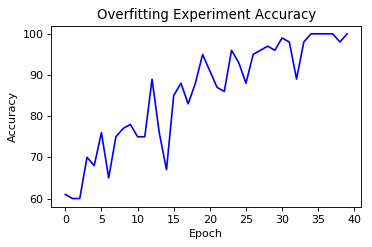

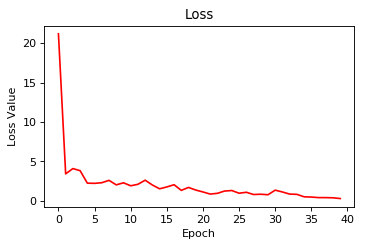

In [135]:
figure(figsize=(5, 3), dpi=80)
plt.title('Overfitting Experiment Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, color='b')

plt.show()

figure(figsize=(5, 3), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, color='r')
plt.show()

# Setting up the actual model:

### Defining the Dataset object:

In [137]:
dataset = MoleDataset(transform=image_preprocessing)

### Splitting the dataset into train, validation, and test sets:

In [164]:
# Defining the proportions of how the dataset will be split:
train_proportion = 0.8
validation_proportion = 0.1
test_proportion = 0.1

# Defining the sized of the splits:
train_size = math.ceil(train_proportion * len(dataset))
validation_size = math.ceil(validation_proportion * len(dataset))
test_size = math.floor(test_proportion * len(dataset))

# Defining the train, validation, and test sets:
train_set, validation_set = random_split(dataset, [train_size, validation_size + test_size])
test_set, validation_set = random_split(validation_set, [test_size, validation_size])

print(f"Train set size: {train_size} | Validation set size: {validation_size} | Test set size {test_size}")

Train set size: 8012 | Validation set size: 1002 | Test set size 1001


### Creating the DataLoader objects:

In [171]:
train_batch_size, validation_batch_size, test_batch_size = 8, 8, 16

train_loader = DataLoader(train_set, shuffle=True, batch_size=train_batch_size)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=validation_batch_size)
test_loader = DataLoader(test_set, shuffle=True, batch_size=test_batch_size)

### Creating the model:

In [172]:
model = SkinCancerModel()

### Defining the optimizer, criterion, and hyperparameters:

In [173]:
learning_rate = 1e-3

# loss_weights = None
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weights=loss_weights)

### Defining the number of epochs:

In [174]:
epochs = 10

# Training the model

In [175]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model,
                                                                            train_loader=train_loader,
                                                                            validation_loader=validation_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating epoch...


 10%|█         | 1/10 [07:31<1:07:40, 451.16s/it]

Epoch: 0 | Train_acc: 67.44% | Val_acc: 67.47% | Loss: 1869.57 | Runtime: 451.16 seconds
Evaluating epoch...


 20%|██        | 2/10 [15:07<1:00:32, 454.06s/it]

Epoch: 1 | Train_acc: 69.23% | Val_acc: 70.16% | Loss: 954.35 | Runtime: 456.09 seconds
Evaluating epoch...


 30%|███       | 3/10 [22:41<52:57, 453.96s/it]  

Epoch: 2 | Train_acc: 69.66% | Val_acc: 71.36% | Loss: 887.93 | Runtime: 453.84 seconds
Evaluating epoch...


 30%|███       | 3/10 [27:04<1:03:11, 541.66s/it]


KeyboardInterrupt: 

In [ ]:
figure(figsize=(5, 3), dpi=80)
plt.title('Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, color='b')

plt.show()

figure(figsize=(5, 3), dpi=80)
plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, color='r')
plt.show()